In [3]:
# HW1Q3.ipynb
# Date: 07/30/2021
# Author: Rio Weil
# Functionality: Calculates the concatenation threshold for the 9-qubit Shor Code under independent depolarizing Pauli noise analytically.
# Note: The errors under concatenation are found by counting 4^9 possible combinations (inefficient).

In [8]:
import numpy as np
import matplotlib.pyplot as plt

We now proceed to compute the error threshold analytically by using a computer program to check all cases. We start by initializing some empty lists.

In [66]:
gatelist = np.array(["I", "X", "Y", "Z"])
pxlist = []
pylist = []
pzlist = []

We now define some helper functions to declare whether a net X or Z error occured on a given block:

In [56]:
def checkx(q1, q2, q3):
    if q1 == "X" or q1 == "Y":
        x1 = 1
    else:
        x1 = 0
    if q2 == "X" or q2 == "Y":
        x2 = 1
    else:
        x2 = 0
    if q3 == "X" or q3 == "Y":
        x3 = 1
    else:
        x3 = 0
    if (x1 + x2 + x3) > 1:
        return 1
    else:
        return 0

def checkz(q1, q2, q3):
    if q1 == "Z" or q1 == "Y":
        z1 = 1
    else:
        z1 = 0
    if q2 == "Z" or q2 == "Y":
        z2 = 1
    else:
        z2 = 0
    if q3 == "Z" or q3 == "Y":
        z3 = 1
    else:
        z3 = 0
    return (z1 + z2 + z3) % 2

Now, we iterate over all $4^9$ possible combinations of errors, and record which error combinations result in a logical $X$, $Y$, or $Z$ error.

In [95]:
for a in gatelist:
    for b in gatelist:
        for c in gatelist:
            for d in gatelist:
                for e in gatelist:
                    for f in gatelist:
                        for g in gatelist:
                            for h in gatelist:
                                for i in gatelist:
                                    error = a + b + c + d + e + f + g + h + i
                                    xerr = False
                                    zerr = False
                                    xcheck1 = checkx(a, b, c)
                                    xcheck2 = checkx(d, e, f)
                                    xcheck3 = checkx(g, h, i)
                                    if ((xcheck1 + xcheck2 + xcheck3) % 2) == 1:
                                        xerr = True
                                    zcheck1 = checkz(a, b, c)
                                    zcheck2 = checkz(d, e, f)
                                    zcheck3 = checkz(g, h, i)
                                    if (zcheck1 + zcheck2 + zcheck3) > 1:
                                        zerr = True
                                    if xerr:
                                        if zerr:
                                            pylist.append(error)
                                        else:
                                            pxlist.append(error)
                                    else:
                                        if zerr:
                                            pzlist.append(error)

Before we pass these tabulated results to the symbolic calculator, we first simplify. We group errors in terms of their error classes (i.e. the name number of each type of error). An example would be that "IIIIIIIXX" and "XXIIIIIII" would be in the same error class. As such, we make a function that counts the anagrams of each error type, and groups them together.

In [96]:
def create_anagrams_list(wordlist):
    sortedlist = []
    for i in range(len(wordlist)):
        wordlist[i] = sorted(wordlist[i])
    while (len(wordlist) != 0):
        word = wordlist[0]
        count = 0
        for i in range(len(wordlist)):
            if (word == wordlist[i]):
                count += 1
        for i in range(count):
            wordlist.remove(word)
        sortedlist.append([word, count])   
    return sortedlist

In [97]:
def process_list(almost_done):
    for i in range(len(almost_done)):
        word = ""
        for j in range(9):
            word += almost_done[i][0][j]
        almost_done[i] = [word, almost_done[i][1]]

With these functions created, we just need to run them on each of the outputs of the error counter. Note that this is *very* slow. In particular the way I wrote the anagram counter is $O(n^2)$. This could be improved using a dictionary (reducing this to $O(n)$) but I was lazy (and in theory, we just run this the one time and never again). Note that it does take > 5 minutes per processing.

In [168]:
sorted_pxlist = create_anagrams_list(pxlist)

In [169]:
process_list(sorted_pxlist)

In [98]:
sorted_pylist = create_anagrams_list(pylist)

In [99]:
process_list(sorted_pylist)

In [101]:
sorted_pzlist = create_anagrams_list(pzlist)

In [102]:
process_list(sorted_pzlist)

In [114]:
#print(sorted_pxlist)
#print(sorted_pylist)
#print(sorted_pzlist)

Now, we use sympy to help us with some of the algebra.

In [4]:
from sympy import *

We will use $x, y, z$ to denote $p_x, p_y, p_z$ (where these are the physical error rates)

In [107]:
x, y, z = symbols("x y z")

This function takes in the sorted list of errors, and produces a symbolic expression of the concatenated error.

In [117]:
def make_symbolic(sortedlist):
    finalexpr = 0
    for i in range(len(sortedlist)):
        string = sortedlist[i][0]
        expr = sortedlist[i][1]
        for j in range(len(string)):
            if string[j] == "X":
                expr *= x
            elif string[j] == "Y":
                expr *= y
            elif string[j] == "Z":
                expr *= z
            else:
                expr *= (1 - x - y - z)
        finalexpr += expr
    return finalexpr

Below we have $p_x, p_y, p_z$ where these represent the logical error after one level of concatenation of the 9-qubit Shor code.

In [170]:
px = make_symbolic(sorted_pxlist)
py = make_symbolic(sorted_pylist)
pz = make_symbolic(sorted_pzlist)

In [176]:
simplify(pz)

Above is $p_{z}$ (logical Z error rate after concatenation), *after* simplifying. It doesn't look particularly pleasant at all to deal with. But, we can apply our trick of $p = p_x + p_y$, $q = p_y + p_z$ and see what we get...

In [172]:
pvar = px + py

In [173]:
qvar = py + pz

In [174]:
simplify(pvar)

In [175]:
simplify(qvar)

Wonderfully, after making these substitutions, we notice that the two relations decouple! We see no terms of $z$ in the former and no terms of $x$ is the latter. Let's make sympy factor these...

In [5]:
p, q = symbols("p, q")

In [178]:
factor(pvar)

After a little algebra by hand to do the substitution of $x + y \rightarrow p$, we have:

In [179]:
newp = -p**2 * (2*p - 3) * ( 16 * p**6 -48 * p**5 + 36 * p**4 + 12 * p**3 - 18 * p**2 + 3)
newp

In [180]:
expand(newp)

Next looking at $q$:

In [181]:
factor(qvar)

After a little algebra by hand to do the substitution of $y + z \rightarrow q$, we have:

In [6]:
newq = -q**2 * (4*q**2 - 6 * q + 3)**2 * (8 * q**3 - 12*q**2 + 6*q - 3)
newq

-q**2*(4*q**2 - 6*q + 3)**2*(8*q**3 - 12*q**2 + 6*q - 3)

In [7]:
expand(newq)

-128*q**9 + 576*q**8 - 1152*q**7 + 1344*q**6 - 1008*q**5 + 504*q**4 - 162*q**3 + 27*q**2

We therefore have obtained the decoupled recursion relations:
$$p_x + p_y = p \mapsto -32p^9 + 144p^8 - 216p^7 + 84p^6 + 72p^5 - 54p^4 - 6p^3 + 9p^2$$
$$p_y + p_z = q \mapsto -128q^9 + 576q^8 - 1152q^7 + 1344q^6 - 1008q^5 + 504q^4 - 162q^3 + 27q^2$$

To solve for the concatenation threshold for $p, q$, we solve the equation $p_{n+1} = p_n$, $q_{n+1} = q_n$ to get that $p_t = 0.13514$, $q_t = 0.04985$. Taking the lower (tighter) bound of the two, we have that $q_t = 0.04985$, hence $\frac{p}{3} + \frac{p}{3} = p_y + p_z = q_t = 0.04985$ which gives a final threshold of $p_{threshold} = 0.074$; in shockingly good agreement with the numerical simulation!

Let's try to find an analytical expression. First, we might find it useful to make some plots.

In [9]:
def pconcat(p):
    return -32*p**9 + 144*p**8 - 216*p**7 + 84*p**6 + 72*p**5 - 54*p**4 - 6*p**3 + 9*p**2

def qconcat(q):
    return -128*q**9 + 576*q**8 - 1152*q**7 + 1344*q**6 - 1008*q**5 + 504*q**4 - 162*q**3 + 27*q**2


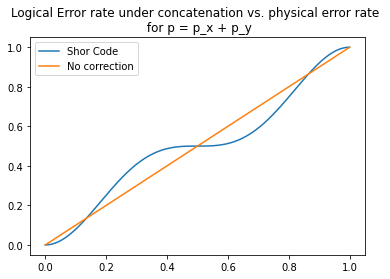

In [10]:
xaxis = np.linspace(0, 1, 1001)
plt.plot(xaxis, pconcat(xaxis), label = "Shor Code")
plt.plot(xaxis, xaxis, label = "No correction")
plt.legend(loc = "best")
plt.title("Logical Error rate under concatenation vs. physical error rate \n for p = p_x + p_y")
plt.show()

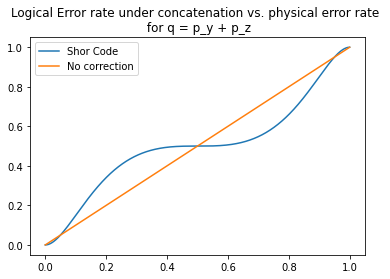

In [12]:
xaxis = np.linspace(0, 1, 1001)
plt.plot(xaxis, qconcat(xaxis), label = "Shor Code")
plt.plot(xaxis, xaxis, label = "No correction")
plt.legend(loc = "best")
plt.title("Logical Error rate under concatenation vs. physical error rate \n for q = p_y + p_z")
plt.savefig("qplot.pdf")
plt.show()

Let us use this plot to try to obtain an analytical answer to $q_{n+1} = q_n$ (the concatenation threshold) that we solved numerically last time (we can ignore the $p_{n+1} = p_n$ relation as we already determined that the $q$s provide the tighter bound (and hence the overall threshold that we solve for). 

From the above plot, we can already see three roots of the equation:
$$-128q^9 + 576q^8 - 1152q^7 + 1344q^6 - 1008q^5 + 504q^4 - 162q^3 + 27q^2 - q = 0$$

Namely, $q = 0, q = 0.5, q = 1$. Let us factor these out and see if our expression simplifies in any meaningful way. Note that we also see that there are roots at $q', 1 - q'$ for some yet undetermined $q' \in (0, 1)$. 

$$q(-128q^8 + 576q^7 - 1152q^6 + 1344q^5 - 1008q^4 + 504q^3 - 162q^2 + 27q - 1) = 0$$

The algebra gets a bit tedious, so I pass it to sympy.

In [11]:
newq = -q**2 * (4*q**2 - 6 * q + 3)**2 * (8 * q**3 - 12*q**2 + 6*q - 3) - q
newq

-q**2*(4*q**2 - 6*q + 3)**2*(8*q**3 - 12*q**2 + 6*q - 3) - q

In [12]:
factor(newq)

-q*(q - 1)*(2*q - 1)*(64*q**6 - 192*q**5 + 256*q**4 - 192*q**3 + 88*q**2 - 24*q + 1)

We have now factored out the roots at $q=0, q = 1, q = 1/2$. We are left with a sextic polynomial, which by inspection (of the plot) has roots $q', (1-q') \in (0, 1)$. The rest of the roots are imaginary, as past $q = 0$ and $q = 1$, the plots of $q_{n+1} = q$ and $q = q$ quickly diverge:

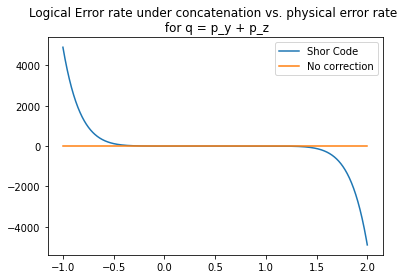

In [16]:
xaxis = np.linspace(-1, 2, 1001)
plt.plot(xaxis, qconcat(xaxis), label = "Shor Code")
plt.plot(xaxis, xaxis, label = "No correction")
plt.legend(loc = "best")
plt.title("Logical Error rate under concatenation vs. physical error rate \n for q = p_y + p_z")
plt.show()

In [17]:
partq = 64*q**6-192*q**5+256*q**4-192*q**3+88*q**2-24*q+1

In [21]:
partq

64*q**6 - 192*q**5 + 256*q**4 - 192*q**3 + 88*q**2 - 24*q + 1

Of course, not all degree-6 polynomials are solvable (Galois has shown that in general, a closed form expression for the roots of a degree $n$ polynomial only exists for $n \leq 4$). However, if the polynomial has a special form, there are methods that one can solve for the roots; "General Formulas for Solving Solvable Sextic Equations" by Hagedorn gives methods to check if sextic polynomials are of solvable type and if so, the analytic expressions. might be also worth looking into the sympy solver and see how it actually solved it. https://github.com/sympy/sympy/blob/46e00feeef5204d896a2fbec65390bd4145c3902/sympy/solvers/solvers.py#L379-L1278

After discussion with Robert today, we make the observation that we can actually be quite a bit more clever. Noticing the symmetry of the polynomial $q_{n+1}$ about 0.5, we can shift the polynomial around this point, which will simplify our root finding significantly:

In [19]:
oldq = -q**2 * (4*q**2 - 6 * q + 3)**2 * (8 * q**3 - 12*q**2 + 6*q - 3) - q

In [20]:
expand(oldq)

-128*q**9 + 576*q**8 - 1152*q**7 + 1344*q**6 - 1008*q**5 + 504*q**4 - 162*q**3 + 27*q**2 - q

Making the substiution $q - 0.5 = w$, we get:

In [26]:
w = symbols('w')

In [30]:
wshifted = oldq.subs(q, w+0.5)

In [31]:
expand(wshifted)

-128*w**9 + 6.0*w**3 - 1.0*w

In [34]:
wshifted = -128*w**9 + 6*w**3 - w

In [35]:
wshifted

-128*w**9 + 6*w**3 - w

Now of course, we can factor this expression; we will have a root at $w = 0$ (i.e. the root $q = 0.5$) and roots at $w = \pm 0.5$ (i.e. the roots $q = 0, 1$).

In [36]:
factor(wshifted)

-w*(2*w - 1)*(2*w + 1)*(32*w**6 + 8*w**4 + 2*w**2 - 1)

At first, it seems like we haven't gained anything, and we still have a degree 6 polynomial. However, this *is* actually a significant change; notice that due to this clever substitution, the degree-6 polynomial can actually be viewed as a degree 3 polynomial in $w^2$. Letting $x = w^2$, we have:

In [37]:
deg6w = 32*w**6 + 8*w**4 + 2*w**2 - 1

In [39]:
x = symbols('x')

In [40]:
deg3x = deg6w.subs(w, sqrt(x))

In [41]:
deg3x

32*x**3 + 8*x**2 + 2*x - 1

We can now use the cubic formula to solve for the roots of $32x^3 + 8x^2 + 2x - 1 = 0$. We let sympy do this for us here, but in principle any calculator (or human) could do this (https://en.wikipedia.org/wiki/Cubic_equation):

In [42]:
solve(deg3x)

[-1/12 + (-1/2 - sqrt(3)*I/2)*(61/3456 + sqrt(417)/1152)**(1/3) - 1/(72*(-1/2 - sqrt(3)*I/2)*(61/3456 + sqrt(417)/1152)**(1/3)),
 -1/12 - 1/(72*(-1/2 + sqrt(3)*I/2)*(61/3456 + sqrt(417)/1152)**(1/3)) + (-1/2 + sqrt(3)*I/2)*(61/3456 + sqrt(417)/1152)**(1/3),
 -1/12 - 1/(72*(61/3456 + sqrt(417)/1152)**(1/3)) + (61/3456 + sqrt(417)/1152)**(1/3)]

The third solution is real and hence the only one of our interest. We can then take the square root of this solution to obtain the two (plus/minus) roots for $w$, as $w = x^2$. Taking the negative one of these and adding 0.5, we hence obtain the smallest nonzero root of $q$, which is exactly what we were solving for.

In [47]:
sol = -sqrt(-1/12 - 1/(72*(61/3456 + sqrt(417)/1152)**(1/3)) + (61/3456 + sqrt(417)/1152)**(1/3))
sol += 0.5
print(round(sol, 5))

0.04985


So 
$$
-\sqrt{-\frac{1}{12} - \frac{1}{72*(61/3456 + \sqrt{417}/1152)^{1/3}} + (61/3456 + \sqrt{417}/1152)^{1/3}} + \frac{1}{2}
$$
is the analytical expression for our threshold for $q$ (we can see it agrees numerically with our prior calculation). Multiplying this by 3/2 yields the analytical expression for the threshold of the physical error rate $p$, as the question asks. 